<a href="https://colab.research.google.com/github/Jeff-AB/ECE542FinalProject/blob/jeff-development/ECE542FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 542 Final Project

## How to Develop Code for the ECE 542 Final Project

We will be using jupyter notebooks and Google Codelabs to develop our image segmentation application. Each user will work from the same notebook using branches. Here is our strategy to use branches. 

1.   Create a public github account(not a NCSU account). Request an invite to the repository from Jeff, and you will receive an email at the account linked to your github with an access link.

2.   Perform the following command to create a local repository on your computer


## Upload Rules
Upload your changes to your branch only. When you think that your changes are sufficient, make a pull request to the master branch from your personal branch and assign other members to review it. After a branch has been merged, everyone has to update their setups with the new master branch. You will be notified of this in the slack channel

## Model Summary

<img src=https://ronjian.github.io/assets/Mask-RCNN/mask-rcnn.png width="500">

# Setup

Mounts the Google Drive and allows for image preprocessing and augmentation, if desired. 

In [0]:
!pip install tf-nightly-gpu

In [0]:
from os import path
import sys


# Google Colab or Local Notebook Settings
colab_notebook = False

data_dir = None
aug_data_dir = None

# Assign path variables
if colab_notebook:
    #Mount Google Drive Folder
    from google.colab import drive
    
    mount_dir = '/content/drive'
    drive.mount(mount_dir)
    
    data_dir = '/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/'
    aug_data_dir = '/content/drive/My Drive/ECE 542 Final Project/aug_data/'

    # Append local libraries
    MASK_ROOT = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/')
    CIT_ROOT = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/cityscapesScripts/')
    
    # Create Data Directory and extract zip file
    from os import path, mkdir
    import subprocess
    if not path.exists('/content/drive/My Drive/ECE 542 Final Project/data'):
        mkdir('/content/drive/My Drive/ECE 542 Final Project/data')
        subprocess.call(
            [
                'unzip', 
                '/content/drive/My Drive/ECE 542 Final Project/bdd100k_seg.zip', 
                '-d', 
                '/content/drive/My Drive/ECE 542 Final Project/data'
            ]
        )
        
else:
    data_dir = 'data/bdd100k/seg/'
    aug_data_dir = 'aug_data/'
    annotations_dir = 'data/bdd100k/labels/'
    
    # Append local libraries
    MASK_ROOT = os.path.abspath('Mask_RCNN/')
    CIT_ROOT = os.path.abspath('cityscapesScripts/')
    
    
if not path.exists(aug_data_dir):
    mkdir(aug_data_dir)
    mkdir(aug_data_dir + 'images')
    mkdir(aug_data_dir + 'labels')

try:
    import mcrnn
except:
    sys.path.append(MASK_ROOT)
    
    
try:
    import cityscapescripts
except:
    sys.path.append(CIT_ROOT)

TensorFlow 1.x selected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Augmentation

In [1]:
"""

%matplotlib inline
# Data Augmentation Section
'''
This section contains the classes and functions needed to
augment the data for use with MaskRCNN
'''
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from os import listdir, walk
from os.path import isfile, join

from pprint import pprint
from matplotlib import pyplot as plt

import cv2
import random
import numpy as np
import gc

clpt = 'color_labels/train/'
clpv = 'color_labels/val/'

lpt = 'labels/train/'
lpv = 'labels/val/'

impt = 'images/train/'
impv = 'images/val/'

num_final_images = 40000 # 40K images to start
testing = True

class SegmentedDataAugmenter:
    '''
    Consumes 3GiB-5GiB of space while running
    '''
    def __init__(self, pair_list, num_images_desired, batch_size=32):
        self.num_images = num_images_desired
        self.raw_image_pairs = []
        self.preprocessed_image_batch = []
        self.file_pairs = pair_list
        self.MaskRCNN_width = 1024
        self.MaskRCNN_height = 1024
        self.batch_size = batch_size

        # Dictionary of arguments for ImageDataGenerator
        self.augment_args = {
            'featurewise_center': False,
            'samplewise_center': False,
            'featurewise_std_normalization': False,
            'samplewise_std_normalization': False,
            'zca_whitening': False,
            'zca_epsilon': 1e-06,
            'rotation_range': 0.0,
            'width_shift_range': 0.0,
            'height_shift_range': 0.0,
            'brightness_range': None,
            'shear_range': 0.0,
            'zoom_range': 0.0,
            'channel_shift_range': 0.0,
            'fill_mode': 'nearest',
            'cval': 0.0,
            'horizontal_flip': False,
            'vertical_flip': False,
            'rescale': None,
        }
        self.augment_args = {
            'featurewise_center': False,
            'samplewise_center': False,
            'featurewise_std_normalization': False,
            'samplewise_std_normalization': False,
            'zca_whitening': False,
            'zca_epsilon': 1e-06,
            'rotation_range': 120,
            'width_shift_range': 0.2,
            'height_shift_range': 0.2,
            'brightness_range': None,
            'shear_range': 0.0,
            'zoom_range': 0.0,
            'channel_shift_range': 0.0,
            'fill_mode': 'nearest',
            'cval': 0.0,
            'horizontal_flip': True,
            'vertical_flip': False,
            'rescale': None,
        }
        
        if num_images_desired < batch_size:
            raise Exception('Undefined behavior with batch size larger than total number of images')
                
    def load_images(self):
        # Generator function that returns list of label, image tuples 'batch_size' amount at a time
        '''
        Can optimize this by working a tuple of a numpy array rather than a list of image tuples and 
        combining load_images and preprocess_images. Leaving it this way in case we need access to the 
        raw images for whatever reason later.
        
        The generator here is used to limit the number of images in memory at a time. Once the images
        this function yields are dereferenced, the memory is freed by Python's garbage collector.
        '''
        reducing_file_list = self.file_pairs
        while self.batch_size < len(reducing_file_list):
            self.raw_image_pairs = [] #Dereference old images
            for label_file, image_file in reducing_file_list[:self.batch_size]:
                label_img = cv2.imread(label_file)
                image = cv2.imread(image_file)
                self.raw_image_pairs.append((label_img, image))
            reducing_file_list = reducing_file_list[self.batch_size:]
            yield self.raw_image_pairs
            
        self.raw_image_pairs = [] #Dereference old images
        for label_file, image_file in reducing_file_list[:self.batch_size]:
            label_img = cv2.imread(label_file)
            image = cv2.imread(image_file)
            self.raw_image_pairs.append((label_img, image))
        yield self.raw_image_pairs           
        
    def nodistort_resize_image(self, image):
        '''
        The idea here is to rescale the image then crop out the excess. We lose some information, but I think
        this will give better results than scaling down the image and padding the empty vertical space
        with zeros. We can test this if need be.
        '''
        goal_height = self.MaskRCNN_height
        goal_width = self.MaskRCNN_width
        img_shape = image.shape
        
        #Rescale image to eliminate all padding in final image
        scale_factor = goal_height / img_shape[0]
        dest_size = (int(img_shape[1] * scale_factor), int(img_shape[0] * scale_factor) )
        resized = cv2.resize(image, dest_size)
        
        #Horizonally crop new image
        img_shape = resized.shape
        del_width = img_shape[1] - goal_width 
        resized = resized[:,int(del_width/2):int(-del_width/2),:]
        return resized
    
    def preprocess_images(self):
        # Generator function that preprocesses x number of images at a time
        # It is done this way rather than using the preprocessor argument in ImageDataGenerator
        # so we can have the resized data available without augmentation
        for batch_list in self.load_images():
            self.preprocessed_image_batch = [] #Make preprocessed image batch accessible outside of the class
            for segmenting_pair in batch_list:
                label = self.nodistort_resize_image(segmenting_pair[0])
                image = self.nodistort_resize_image(segmenting_pair[1])
                self.preprocessed_image_batch.append((label, image))
            yield self.preprocessed_image_batch
    
    def process_images(self, save_dir_base=None):
        # Generator function that augments the data in batches or saves them to files
        
        # Calculate the number of times to cycle image generator for each preprocessed batch
        num_augment = int(self.num_images/len(self.file_pairs))
        
        if num_augment < 1:
            raise Exception('Too few images requested')

        for image_batch in self.preprocess_images():
            labels, images = map(list, zip(*image_batch))
            
            # Convert to numpy arrays
            images = np.array(images)
            labels = np.array(labels)
            
            # Use ImageDataGenerator to augment batch
            label_augment = ImageDataGenerator(**self.augment_args)
            image_augment = ImageDataGenerator(**self.augment_args)
            
            
            # We need to ensure that the seeds are the same so that the same transformations are applied
            seed = random.randint(0,65000)
            '''
            This is set up to generate a set number of augmented images for each batch of raw images such that raw images are
            equally represented in the augmented image data set
            '''
            aug_label_gen = label_augment.flow(x=labels, batch_size=self.batch_size, seed=seed) 
            aug_img_gen = image_augment.flow(x=images, batch_size=self.batch_size, seed=seed)
            
            for i in range(0, num_augment):
                label_batch = next(aug_label_gen)
                image_batch = next(aug_img_gen)
                yield (label_batch, image_batch)

def save_preprocessed_to_directory():
    pass

def save_augmented_to_directory(num_augmented_images):
    
    # Check if augmented data directory is empty
    # Assume correct subdirectories were made
    for dirpath, dirnames, filenames in walk(aug_data_dir):
        if filenames:
            raise Exception("Augmented data directory is not empty")


    # Generate File Lists from Training Directory
    color_labels_train = [ data_dir + clpt + cl for cl in listdir(data_dir + clpt) if isfile(join(data_dir + clpt, cl)) ] 
    images_train = [ data_dir + impt + img for img in listdir(data_dir + impt) if isfile(join(data_dir + impt, img)) ]

    # Images with label map pair have the same file prefix
    color_labels_train.sort()
    images_train.sort()

    data_pairs = list(zip(color_labels_train, images_train))
    image_augment = SegmentedDataAugmenter(data_pairs, num_augmented_images) 
    augmented_data_generator  = image_augment.process_images()
    
    label_path = aug_data_dir + 'labels/'
    image_path = aug_data_dir + 'images/'
    index = 0
    
    for label_batch, image_batch in augmented_data_generator:
        #Assume these tensors have the same shape
        for i in range(0,image_batch.shape[0]):
            label_file_name = label_path + 'label-' + str(index) + '.png'
            image_file_name = image_path + 'image-' + str(index) + '.png'
            index+=1
            
            Image.fromarray(image_batch[i].astype(np.uint8)).save(image_file_name)
            Image.fromarray(label_batch[i].astype(np.uint8)).save(label_file_name)
        # We need aggressive garbage collecting to keep from using all the memory
        gc.collect() # clean up after every batch

# Save augmented data
try:
    save_augmented_to_directory(10240)
except Exception as e: 
    print(e)
finally:
    gc.collect() # This should get rid of the dereferenced objects in the function

Using TensorFlow backend.


name 'aug_data_dir' is not defined


# Instance Mask Extraction

Includes dataset class definitions

In [0]:
# Instance Mask Extraction
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import os
import random
    
from mrcnn.utils import Dataset
from cityscapesscripts.helpers.csHelpers import getCoreImageFileName

class CityscapesSegmentationDataset(Dataset):
    
    def load_cityscapes(self, root_directory, subset):
        if subset == 'train':
            self.data_dir = os.path.join(root_directory, 'train')
        elif subset == 'val':
            self.data_dir = os.path.join(root_directory, 'val')
        elif subset == 'test':
            self.data_dir = os.path.join(root_directory, 'test')
        else:
            raise Exception('No valid subset provided')
        
        # Create dictionary to house all files according to their image_id
        image_id_set = set()
        for root, dirs, filenames in os.walk(self.data_dir):
             for filename in filenames:
                image_id_set.add(getCoreImageFileName(filename))
        
        self._image_ids = list(image_id_set)
        #TODO Move remainder of annotation information to Dataset Class
        
    def load_mask(self, image_id):
        '''
        Loads mask corresponding to an image id
        
        image_id: the unique id of the form city_sequenceNb_frame_Nb
        
        returns a bool array of masks and a list of class ids
        The polygons are extracted from the json files and constructed into a binary image
        using PIL. 
        '''
        
        city = image_id.split('_')[0] # First element in list should be city
        annotation_path = os.path.join(os.path.join(self.data_dir, city), image_id + '_gtFine_polygons.json')
        ann_dict = {}
        
        with open(annotation_path) as annotation:
            ann_dict = json.load(annotation)
        masks = []
        class_ids = []
        
        for obj in ann_dict['objects']:
            class_ids.append(obj['label'])
            mask = Image.new(mode = '1', size = (ann_dict['imgWidth'], ann_dict['imgHeight']))
            draw = ImageDraw.Draw(mask)
            
            try:
                points = obj['polygon']
            except:
                print('no polygons for {}'.format(obj['label']))
            
            # PIL expects a tuple of tuples for points
            points = [tuple(coords) for coords in points]
            points = tuple(points)
            
            draw.polygon((points), fill=1)
            masks.append(mask)
        
        masks = np.stack(masks)
        return masks, class_ids

class DeepDriveDataset(utils.Dataset):

    def load_deep_drive(self, dataset_dir):
        '''
        Load a subset of the Berkeley deep drive dataset
        dataset_dir: Root directory of the dataset
        subset: Subset to load. Name of the sub-directory,
                such as train, val, ...etc
        '''
        # Add classes. We have 22 classes.
        # Naming the dataset deep_drive
        # Begin with 1 label (background: 0)
        for i, name in enumerate(class_names):
            self.add_class('deep_drive', i+1, name)

        # Get image ids from dataset_dir
        image_fps = []

        for root, directories, files in os.walk(dataset_dir):
            for f in files:
                image_fps.append(os.path.join(root, f))
                print('file found')

        # Add images
        for i, fp in enumerate(image_fps):
            self.add_image(
                "deep_drive",
                image_id=i + 1,
                path=fp,
                orig_height=1024, 
                orig_width=1024)
            print(i)
            print(fp)

    def load_mask(self, image_id):
        '''
        TODO
        Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        '''
        pass

    def image_reference(self, image_id):
        '''Return the path of the image.'''
        pass
            
'''
# Testing
csds = CityscapesSegmentationDataset()
csds.load_cityscapes('data/gtFine/', 'val')
masks, class_ids = csds.load_mask('frankfurt_000000_000294')
num_instances = len(class_ids)
select = random.randint(0,num_instances - 1)

print(class_ids[select])
fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(np.asarray(masks[select]), cmap=plt.cm.gray)
'''

# Model Setup

Run this cell in order to setup the file structure that Mask R-CNN will expect to use. This includes MODEL_DIR for saving models, 

*   `MODEL_DIR`: directory to write trained models to
*   `COCO_MODEL_PATH`: directory to read trained models in from
*   `IMAGE_DIR`: directory root for image data (training and testing)

TODO: merge this with the Cityscapes Dataset Block above


In [0]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/')
ROOT_DIR = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/')

print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
#IMAGE_DIR = os.path.join(ROOT_DIR, 'images')
IMAGE_DIR = csds.data_dir

# Directories for loading images
PROJECT_DIR = '/content/drive/My Drive/ECE 542 Final Project/'
label_dir = os.path.join(PROJECT_DIR, 'aug_data/labels')
image_dir = os.path.join(PROJECT_DIR, 'aug_data/images')



/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN


# Model Instantiation for Training

Mask R-CNN model object, 'model' using a weights file and a reference dataset. This cell encapsulates the creation of model data to prevent mistakes and lost information during runtime. 

In [0]:
GPU_COUNT = 1
IMAGES_PER_GPU = 1
LEARNING_RATE = 0.0001
NAME = 'bdd'
NUM_CLASSES = 35 #1+34 # Background (inherited from utils.Dataset) + FG classes (listed below)
WEIGHT_DECAY = 0.0001

class TrainingConfig(coco.CocoConfig):
    # TO-OPT: Set batch size to 20 by default.
    GPU_COUNT = GPU_COUNT
    IMAGES_PER_GPU = IMAGES_PER_GPU
    LEARNING_RATE = LEARNING_RATE
    NAME = NAME
    NUM_CLASSES = NUM_CLASSES
    WEIGHT_DECAY = WEIGHT_DECAY

config = TrainingConfig()
config.display()

# BDD Class names
# Index of the class in the list is its ID. For example, to get ID of
# the parking sign class, use: class_names.index('parking sign')
'''class_names = ['BG', 'banner', 'billboard', 'lane divider', 'parking sign', 'pole', 'polegroup', 'street light',
               'traffic cone', 'traffic device', 'traffic light', 'traffic sign', 'sign frame', 'person', 
               'rider', 'bicycle', 'bus', 'car', 'caravan', 'motorcycle', 'trailer', 'train', 'truck']
               '''

'''
  For loading coco classes
'''
'''
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
'''

'''
  For loading Cityscapes classes
'''

class_names = ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence',
               'guard rail', 'bridge', 'tunnel', 'pole', 'polegroup', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'caravan',
               'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
!pip install pycocotools

In [0]:
# Create model object in training mode.
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO, excepting areas for training
# We can exclude the bounding box layers for now, but they will
# be useful for interpreting our images for now
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_bbox_fc",
                                                           "mrcnn_bbox",
                                                           "mrcnn_mask",
                                                           "mrcnn_class_logits"])

# Dataset organization

TODO: We read in data using the following structure. This will allow us to have annotations stored in a JSON format in one directory with images stored in another with train and val subset labels respectively. 

```
DATA_DIR
│
└───annotations
│   │   bdd100k_labels_images_<subset><year>.json
│   
└───<subset><year>
    │   image021.jpeg
    │   image022.jpeg
```



# Model Training

Run these cells in order to train the Mask R-CNN model's mask and ROI-related layers (excludes CNN backbone layers). 

In [0]:
# Training dataset.
dataset_train = CityscapesSegmentationDataset()
dataset_train.load_cityscapes('data/gtFine/', 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = CityscapesSegmentationDataset()
dataset_val.load_cityscapes('data/gtFine/', 'val')
dataset_val.prepare()

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/images/train/2aecc356-a34c9317.jpg
4501
/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/images/train/2d31d6ab-fa604381.jpg
4502
/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/images/train/31be362f-31e60968.jpg
4503
/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/images/train/249e937c-00000000.jpg
4504
/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/images/train/24a6a304-095969f9.jpg
4505
/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/images/train/2e15befa-8bb8e5d7.jpg
4506
/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/images/train/2cc6e016-d4430001.jpg
4507
/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/images/train/236e681e-3fe83ea1.jpg
4508
/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/images/train/270ed800-2798aa34.jpg
4509
/content/drive/My Driv

In [0]:
model.train(dataset_train, 
            dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=5,
            layers='heads',
            augmentation=None)  

model.train(dataset_train, 
            dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=5,
            layers='4+',
            augmentation=None)  

model.train(dataset_train, 
            dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=5,
            layers='all',
            augmentation=None)  


Starting at epoch 0. LR=0.005

Checkpoint Path: /content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/logs/bdd20200329T2328/mask_rcnn_bdd_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5


ERROR:root:Error processing image {'id': 2072, 'source': 'deep_drive', 'path': '/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/images/train/5eb65dc1-00000000.jpg', 'orig_height': 1024, 'orig_width': 1024}
Traceback (most recent call last):
  File "/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
TypeError: 'NoneType' object is not iterableERROR:root:Error processing image {'id': 2072, 'source': 'deep_drive', 'path': '/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/images/train/5eb65dc1-00000000.jpg', 'orig_height': 1024, 'orig_width': 1024}
Traceback (most recent call last):
  File "/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.

TypeError: ignored

AttributeError: ignored

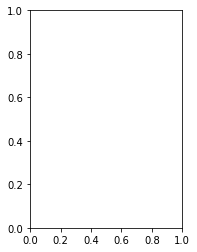

In [0]:
# Retrieve history for plotting loss and accuracy per epoch
history = model.keras_model.history.history

# Accuracy plot config
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Training and Validation Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Training', 'Validation'))
plt.grid()

# Loss plot config
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(('Training', 'Validation'))
plt.grid()

# Display plot
plt.show()

# Model Evaluation

Run these cells in order to receive an evaluation on a test image. First, the new model is selected from among the saved checkpoint models. Then, a configuration is set for inference (the same as before). Then a sample image is labeled using the Berkeley Deep Drive classes.

In [0]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

NameError: ignored

In [0]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=config,
                          model_dir=ROOT_DIR)

model.load_weights(COCO_MODEL_PATH, by_name=True)

In [0]:
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

NameError: ignored

In [0]:
# Load a random image from the images folder
root, dirs, file_names = next(os.walk(IMAGE_DIR))
print(file_names)
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

['932c1c93-91f79869.jpg', '813ac0fa-296a3536.jpg', 'b090bc5d-1adf72c1.jpg', 'af29a474-3c32015c.jpg', 'b0409282-a0efc7da.jpg', 'a40f1068-fc077f35.jpg', '954b31d2-cc4c578a.jpg', '79fbe809-3c0a0517.jpg', 'a4bcd9f0-d150d9a2.jpg', '9f09c4ee-b09fd242.jpg', '7a4e7466-bb01f12a.jpg', '916e293b-0c92f2b7.jpg', '7eb06ba6-74b8ab7b.jpg', '899a1ac2-81e7aff1.jpg', '912e44a6-dc2d2079.jpg', '8a51b26a-9f6d5183.jpg', '8d9a9d66-1c5d5f51.jpg', '7e5568e2-d66c43ff.jpg', '851ec515-15faca1d.jpg', '89136a23-8d74f32f.jpg', '7c2747e6-2a97b7a9.jpg', '7a32fc03-c1010e49.jpg', 'a4adaa33-3c2c518a.jpg', '7ad2aa84-5a05b9be.jpg', 'ab8095e6-c9c6560e.jpg', '96fc04e6-4ca49b3e.jpg', '9e4c3aea-2d4d128f.jpg', '9c0b381f-55758a5e.jpg', '7d24a7cd-daeaf356.jpg', 'a51a039e-1dd6e515.jpg', '7c180959-333171a1.jpg', '9d2c870a-a0b6ac72.jpg', 'af265364-91fdf6d3.jpg', '8a5b5291-79dc07b6.jpg', 'a3b51b78-d5e379c3.jpg', 'a9712a33-bc93e05f.jpg', '8cb281a4-145328a9.jpg', '7c0a7d5a-bf5134a5.jpg', '7acb2160-00000000.jpg', '87e5b8c4-7abcf1c9.jpg',

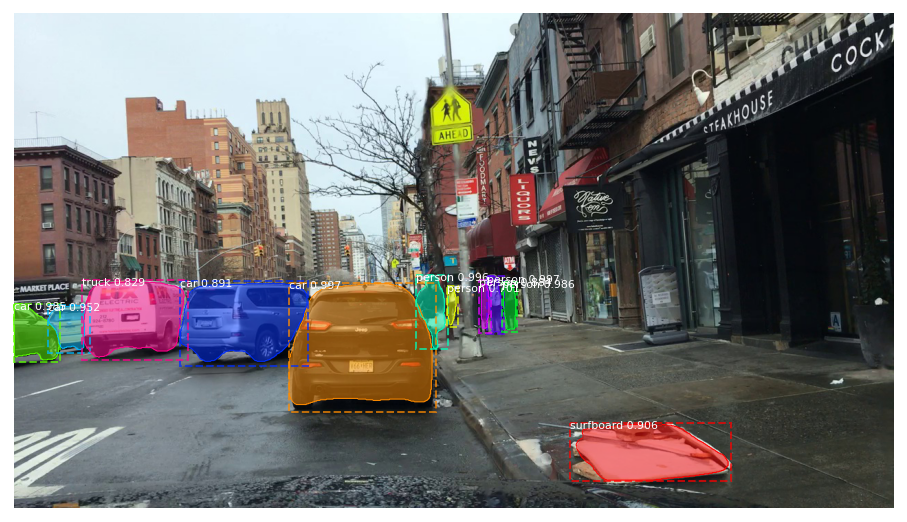

In [0]:
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])